ACORN-SAT Example
==

In this example we demonstrate creating a PhilDB instance and loading the Australian Bureau of Meteorology 'Australian Climate Observations Reference Network – Surface Air Temperature' (ACORN-SAT) data set for analysis.

First up, some imports:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

Create a new PhilDB database
--

The next snippet shows how to create a PhilDB database using the create method. Alternate to the following code the commandline phil-create method could be used (e.g `phil-create acorn_sat`).

In [2]:
from phildb.create import create
create('acorn_sat')

In [3]:
# Get station list as a Pandas DataFrame
station_list = pd.read_csv('http://www.bom.gov.au/climate/change/acorn-sat/map/stations-acorn-sat.txt')

# Create a station_id column from the stn_num column that has zero left-padded IDs to match URLs
station_list['station_id'] = station_list['stn_num'].apply(lambda x: '{0:06d}'.format(x))
station_list.head()

,stn_num,stn_name,lat,lon,elevation,start,station_id
0,1019,Kalumburu,-14.30,126.65,23,1941,001019
1,2012,Halls Creek,-18.23,127.66,422,1910,002012
2,3003,Broome Airport,-17.95,122.24,7,1910,003003
3,4032,Port Hedland,-20.37,118.63,6,1912,004032
4,4106,Marble Bar,-21.18,119.75,182,1910,004106


Accessing a PhilDB instance
--

Once a PhilDB database has been created it can be accessed using the PhilDB database class.
Which after being imported can be used to create a database instance
(which is stored in the 'db' variable here) as follows:

In [4]:
from phildb.database import PhilDB
db = PhilDB('acorn_sat')

Initialise source and measurand attributes
--
Now that we have created and connected to the 'acorn_sat' PhilDB we can initialise source and measurand attributes for identifying temperature time series instances.

In [5]:
source = 'BOM_ACORN_SAT'
frequency = 'D'

db.add_measurand('maxT', 'MAXIMUM_TEMPERATURE', 'Maximum Temperature')
db.add_measurand('minT', 'MINIMUM_TEMPERATURE', 'Minimum Temperature')
db.add_source(source, 'Bureau of Meteorology; Australian Climate Observation Reference Network - Surface Air Temperature dataset.')

Download and load data
--
Use pandas to read each of the data files directly from the Bureau of Meterology website before writing into the PhilDB.

Data source: http://www.bom.gov.au/climate/change/acorn-sat/

In [6]:
for station_id in station_list['station_id']:
    print("Adding timeseries ID: {0}".format(station_id))
    db.add_timeseries(station_id)

    for variable in ['minT', 'maxT']:
        input_url = 'http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.{0}.{1}.daily.txt'.format(
            variable,
            station_id
        )

        print('Loading time series file: {0}'.format(input_url))
        df = pd.read_csv(
            input_url,
            parse_dates = [0],
            index_col = 0,
            header = None,
            skiprows = 1,
            sep = r"\s+",
            na_values = '99999.9',
            names = ['Date', variable]
        )

        db.add_timeseries_instance(station_id, frequency, 'ACORN-SAT', measurand = variable, source = source)
        db.write(station_id, frequency, df[variable], measurand = variable, source = source)

Adding timeseries ID: 001019
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.minT.001019.daily.txt
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.maxT.001019.daily.txt
Adding timeseries ID: 002012
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.minT.002012.daily.txt
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.maxT.002012.daily.txt
Adding timeseries ID: 003003
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.minT.003003.daily.txt
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.maxT.003003.daily.txt
Adding timeseries ID: 004032
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.minT.004032.daily.txt
Loading time series file: http://www.bom.gov.au/climate/change/acorn/sat/data/acorn.sat.maxT.004032.daily.txt
Addi

Calculate Annual mean temperature anomalies for Australia
==
In this section we will attempt to reproduce the "Annual mean temperature anomalies for Australia" plot as seen here:
![Annual mean temperature anomalies for Australia](http://www.bom.gov.au/climate/change/acorn-sat/images/trend-graph.png)
Source: http://www.bom.gov.au/climate/change/acorn-sat/images/trend-graph.png

Collect data
--
Read in all the daily maximum and minimum temperature series for the 1910 to 2014 period:

In [7]:
%time daily_max_t = db.read_all('D', measurand = 'maxT', source = 'BOM_ACORN_SAT').ix['1910':'2014']
%time daily_min_t = db.read_all('D', measurand = 'minT', source = 'BOM_ACORN_SAT').ix['1910':'2014']

CPU times: user 2.85 s, sys: 160 ms, total: 3.01 s
Wall time: 3.06 s
CPU times: user 2.88 s, sys: 142 ms, total: 3.03 s
Wall time: 3.08 s


Calculate daily mean temperatures
--

In [8]:
%time daily_mean_t = (daily_max_t + daily_min_t) / 2

CPU times: user 45 ms, sys: 29 ms, total: 74 ms
Wall time: 65.6 ms


Define a filter method
--
This filter method is used to calculate the annual mean where more than 350 days are available. A nan is returned when less than 350 days of data are available, this prevents the calculation of a mean based of a small amount of data.

In [9]:
def incomplete_year_filter(ts):
    if len(ts.dropna()) > 350:
        return np.mean(ts)
    else:
        return np.nan

Resample to annual means
--
Here we resample to annual means using the incomplete_year_filter method we defined earlier

In [10]:
annual_mean_t = daily_mean_t.resample('AS', how = incomplete_year_filter)

Calculate anomalies
--
Anomalies are calculated as departures are from the 1961--1990 average. Therefore we first calculate the 1961 to 1990 mean for all stations. Then we subtract that baseline from the entire record for all stations. Before finally taking the mean of each year across all stations.

In [11]:
baseline = annual_mean_t.ix['1961':'1990'].mean()
all_anomalies = annual_mean_t - baseline
australian_mean_annual_temperature_anomalies = all_anomalies.mean(axis = 1)

Visualise the results
--
Now we plot the results applying some styles and a rolling mean to be similar to the Bureau of Meterology plot linked earlier.

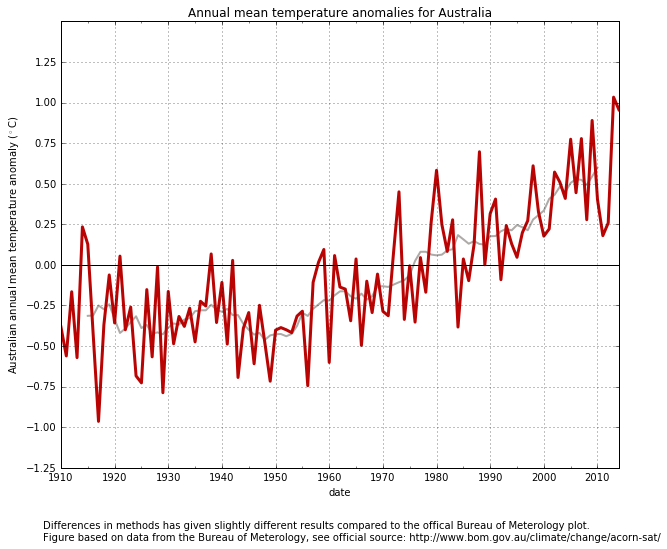

In [12]:
pd.rolling_mean(australian_mean_annual_temperature_anomalies, 10, center = True).plot(color = '#adaaa7', linewidth=2)
australian_mean_annual_temperature_anomalies.plot(color = '#ba0303', linewidth=3, figsize=(10, 8), grid = True)

# Horizontal black line at 0
plt.axhline(0, color='k')

# Set ylimit to match Bureau graph
plt.ylim((-1.25, 1.5))

# Set yticks to match Bureau graph
plt.yticks(np.arange(-1.25, 1.5, 0.25))

# Set xticks to have years at 10 year intervals like the Bureau graph
x_dates = pd.date_range('1910', '2010', freq = '10AS')
plt.xticks(x_dates, x_dates.year)

# Add title ylabel and caption
plt.title('Annual mean temperature anomalies for Australia')
plt.ylabel('Australian annual mean temperature anomaly ($^\circ$C)')
plt.figtext(.1,0, 'Differences in methods has given slightly different results compared to the offical Bureau of Meterology plot.\nFigure based on data from the Bureau of Meterology, see official source: http://www.bom.gov.au/climate/change/acorn-sat/')

Note that while the final figure is close to the original, differences in calculation of anomalies or possibly differences in data used for the original vs currently available data has yielded slightly different results.